### Now that I have a way to get at some pulses from Ca45 data, I can train a GAN to generate pulses.
To do list
* investigate whether training on noisy data is better/faster than on no noise data - use Aaron's simulation
    * done - better to train on noisy data
* Find the difference between Aaron's pulseGen and the cluster centers
* try to cluster pileup events
    * get good clustering params
        * done - saved in 'kmeans' pickle
    * go through and save all the non-noise wfs
    * chop off ends and see if can cluster pileup/no-pileup
        * this should be in Clustering.ipynb
* Get a network that can recognize Aaron's pulse
    * done - did this in the process of testing noisy/not noisy training
* Use this to train a GAN that can generate pulses like Aaron's
* find how the GAN pulses differ from cluster centers

## Imports

In [1]:
import numpy as np
from matplotlib.pyplot import *

In [2]:
import matplotlib.pyplot as plt

In [3]:
from numba import jit

In [4]:
from sklearn.metrics import confusion_matrix

## Data Generators

In [5]:
@jit(nopython=True)
def makeNoPileup(amp, T0):
    wf = np.empty(3500)
    length = len(wf)
    cc_slow = 2.5+0.4*np.random.normal(); cc_slow=cc_slow/(cc_slow+1); ##charge collection slow time constant

    cc_fast = 1./2.5; #charge collection fast time constant
    alpha_cr = 1250./(1250.+1.); #fall time of output
    alpha_rc1 = 1./2.75;
    alpha_rc2 = 1./2.75;
    step=np.zeros(2);charge=np.zeros(2);cur_s=np.zeros(2);cur_f=np.zeros(2);cr=np.zeros(2);rc1=np.zeros(2);rc2=np.zeros(2);
    for i in range(length):
        if i>=T0:
            step[i%2]=1.
        else:
            step[i%2]=0.
        cur_s[i%2]=cc_slow*(cur_s[(i+1)%2]+step[i%2]-step[(i+1)%2]);
        cur_f[i%2]=cc_fast*(cur_s[i%2]-cur_f[(i+1)%2])+cur_f[(i+1)%2];
        charge[i%2]=charge[(i+1)%2]+amp*cur_f[i%2]*(1./cc_slow-1.);
        cr[i%2]=alpha_cr*(cr[(i+1)%2]+charge[i%2]-charge[(i+1)%2]);
        rc1[i%2]=alpha_rc1*(cr[i%2]-rc1[(i+1)%2])+rc1[(i+1)%2];
        rc2[i%2]=alpha_rc2*(rc1[i%2]-rc2[(i+1)%2])+rc2[(i+1)%2];
        wf[i]=rc2[i%2];
    return wf

In [6]:
wf = makeNoPileup(100,1000)

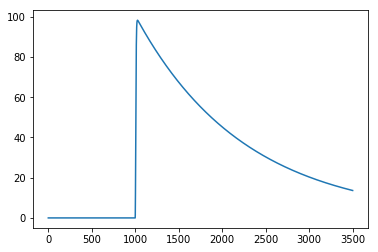

In [7]:
plot(wf)

In [8]:
@jit(nopython=True)
def makePileup(amp, T0, delay, perc):
    wf = np.empty(3500)
    length = len(wf)
    cc_slow = 2.5+0.4*np.random.normal(); cc_slow=cc_slow/(cc_slow+1); ##charge collection slow time constant

    cc_fast = 1./2.5; #charge collection fast time constant
    alpha_cr = 1250./(1250.+1.); #fall time of output
    alpha_rc1 = 1./2.75;
    alpha_rc2 = 1./2.75;
    step=np.zeros(2);charge=np.zeros(2);cur_s=np.zeros(2);cur_f=np.zeros(2);cr=np.zeros(2);rc1=np.zeros(2);rc2=np.zeros(2);
    amp1 = perc*amp
    ampTotal = amp
    T2 = T0+delay
    for i in range(length):
        
        if i>=T2:
            step[i%2]=1.
        elif i>=T0:
            step[i%2]=perc
        else:
            step[i%2]=0.

        cur_s[i%2]=cc_slow*(cur_s[(i+1)%2]+step[i%2]-step[(i+1)%2]);
        cur_f[i%2]=cc_fast*(cur_s[i%2]-cur_f[(i+1)%2])+cur_f[(i+1)%2];
        charge[i%2]=charge[(i+1)%2]+amp*cur_f[i%2]*(1./cc_slow-1.);
        cr[i%2]=alpha_cr*(cr[(i+1)%2]+charge[i%2]-charge[(i+1)%2]);
        rc1[i%2]=alpha_rc1*(cr[i%2]-rc1[(i+1)%2])+rc1[(i+1)%2];
        rc2[i%2]=alpha_rc2*(rc1[i%2]-rc2[(i+1)%2])+rc2[(i+1)%2];
        wf[i]=rc2[i%2];
    return wf

In [19]:
wf = makePileup(100,1000,100,0.5)

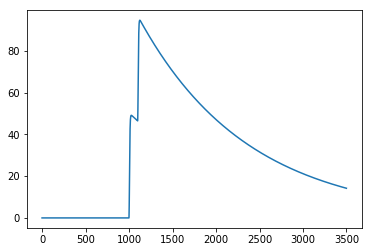

In [20]:
plot(wf)

In [21]:
import numba

In [22]:
@jit(nopython=True, locals={'makePileup':numba.typeof(makePileup), 'makeNoPileup':numba.typeof(makeNoPileup)})
def genBatch(N):
    data = np.empty((N,3500))
    E = np.random.randint(200,2000, size=N)
    T0= np.random.randint(900,1100, size=N)
    p = np.random.random(size=int(N/2))*0.8+0.1
    d = np.random.randint(30,40,size=int(N/2))
    for i in range(int(N/2)):
        data[i] = makeNoPileup(E[i],T0[i])
        data[i] = data[i]*2./np.amax(data[i]) - 1.
    for i in range((int(N/2)),N):
        data[i] = makePileup(E[i],T0[i],d[i-int(N/2)], p[i-int(N/2)])
        data[i] = data[i]*2./np.amax(data[i]) - 1.

    return data.reshape((N,3500,1))

In [23]:
wf = genBatch(10)

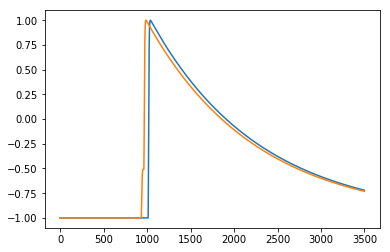

In [24]:
plot(wf[0])
plot(wf[-1])

In [25]:
def genNoisyBatch(N):
    @jit(nopython=True, locals={'makePileup':numba.typeof(makePileup), 'makeNoPileup':numba.typeof(makeNoPileup)})
    def genNoNoise(N):
        data = np.empty((N,3500))
        E = np.random.randint(200,2000, size=N)
        T0= np.random.randint(900,1100, size=N)
        p = np.random.random(size=int(N/2))*0.8-0.1
        d = np.random.randint(30,40,size=int(N/2))

        for i in range(int(N/2)):
            data[i] = makeNoPileup(E[i],T0[i])
        for i in range((int(N/2)),N):
            data[i] = makePileup(E[i],T0[i],d[i-int(N/2)], p[i-int(N/2)])
        return data
    compile_gen = genNoNoise(1)
    
    data = genNoNoise(N)
    noise = np.random.normal(scale=20., size=(N,3500))
    
    noisyData = data + noise
    
    @jit(nopython=True)
    def scale_it(N, noisyData):
        for i in range(N):
            noisyData[i] = noisyData[i]*2./np.amax(noisyData[i]) - 1.

    scale_it(1, data[:1])
    scale_it(N, noisyData)
    
    return noisyData.reshape((N,3500,1))

In [26]:
wf = genNoisyBatch(10)

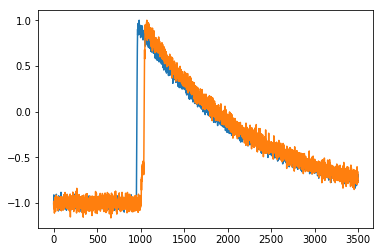

In [27]:
plot(wf[0])
plot(wf[-1])

In [28]:
def getY(data):
    N = len(data)
    y = np.append(np.zeros(int(N/2)),np.ones(int(N-N/2)))
    rnd_state = np.random.get_state()
    np.random.shuffle(data)
    np.random.set_state(rnd_state)
    np.random.shuffle(y)
    return y

## Model Description

In [19]:
from keras.models import Model
from keras.layers import Input, Conv1D, Flatten, BatchNormalization, Activation, Add, Dense, MaxPooling1D
from keras.optimizers import Adam

Using TensorFlow backend.


In [20]:
def resBlock(X, filters, k_size):
    X0 = X
    
    X = MaxPooling1D(pool_size=3)(X)
    X = Conv1D(filters, k_size, padding='same')(X)    
    X = Activation('relu')(X)

    X = MaxPooling1D(pool_size=3)(X)
    X = Conv1D(filters, k_size, padding='same')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling1D(pool_size=3)(X)
    X = Conv1D(filters, k_size, padding='same')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling1D(pool_size=3)(X)  
    
    #X = Add()([X, X0])
    return X

In [21]:
def occam_cnn(F1, K1, input_shape=(3500,1)):
    X_in = Input(input_shape)
    #X = BatchNormalization()(X_in)
    X = resBlock(X_in, F1, K1)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid')(X)
    m = Model(inputs=X_in, outputs=X, name="Occam's CNN")
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

In [22]:
model = occam_cnn(128, 64)

## Model fitting

Compare training on noisy data vs training on non noisy data

In [23]:
X = genBatch(10*1000)
y = getY(X)
model.fit(X, y, epochs=5, batch_size=16)

X = genBatch(10*1000)
y = getY(X)
model.fit(X, y, epochs=5, batch_size=32)

X = genBatch(10*1000)
y = getY(X)
model.fit(X, y, epochs=5, batch_size=64);

Epoch 1/5
10000/10000 [==============================] - 12s 1ms/step - loss: 0.4060 - acc: 0.8065
Epoch 2/5
10000/10000 [==============================] - 11s 1ms/step - loss: 0.2640 - acc: 0.9015
Epoch 3/5
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1851 - acc: 0.9373
Epoch 4/5
10000/10000 [==============================] - 11s 1ms/step - loss: 0.2690 - acc: 0.9012
Epoch 5/5
10000/10000 [==============================] - 10s 1ms/step - loss: 0.2175 - acc: 0.9210
Epoch 1/5
10000/10000 [==============================] - 7s 740us/step - loss: 0.1323 - acc: 0.9581
Epoch 2/5
10000/10000 [==============================] - 7s 712us/step - loss: 0.2421 - acc: 0.9178
Epoch 3/5
10000/10000 [==============================] - 7s 714us/step - loss: 0.2362 - acc: 0.9192
Epoch 4/5
10000/10000 [==============================] - 8s 763us/step - loss: 0.2267 - acc: 0.9212
Epoch 5/5
10000/10000 [==============================] - 7s 734us/step - loss: 0.1302 - acc: 0.9591
Epoch

## Check performance

In [24]:
X_noisy = genNoisyBatch(10*1000)
y = np.append(np.zeros(5000),np.ones(5000))

In [25]:
m = confusion_matrix(np.around(model.predict(X_noisy),0).astype(int), y)
m = 100.*m/sum(m.flatten())
m

array([[39.98,  2.3 ],
       [10.02, 47.7 ]])

In [26]:
model.evaluate(X_noisy, y)

10000/10000 [==============================] - 2s 179us/step


[0.3904408240496647, 0.8768]

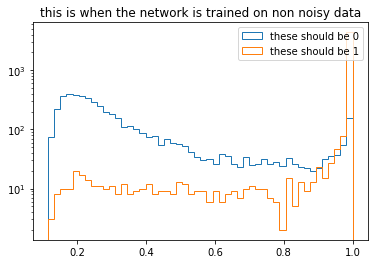

In [27]:
plt.title('this is when the network is trained on non noisy data')
labels_noisy = model.predict(X_noisy[:5000])
plt.hist(labels_noisy, bins=50, histtype='step', label='these should be 0')
plt.yscale('log')
plt.legend();

labels_noisy = model.predict(X_noisy[5000:])
plt.hist(labels_noisy, bins=50, histtype='step', label='these should be 1')
plt.yscale('log')
plt.legend();


In [28]:
model = occam_cnn(128,64)
X = genNoisyBatch(10*1000)
y = getY(X)
model.fit(X, y, epochs=5, batch_size=16)

X = genNoisyBatch(10*1000)
y = getY(X)
model.fit(X, y, epochs=5, batch_size=32)

X = genNoisyBatch(10*1000)
y = getY(X)
model.fit(X, y, epochs=5, batch_size=64);

Epoch 1/5
10000/10000 [==============================] - 11s 1ms/step - loss: 0.4289 - acc: 0.7904
Epoch 2/5
10000/10000 [==============================] - 10s 1ms/step - loss: 0.2511 - acc: 0.9068
Epoch 3/5
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1985 - acc: 0.9325
Epoch 4/5
10000/10000 [==============================] - 10s 1ms/step - loss: 0.1707 - acc: 0.9436
Epoch 5/5
10000/10000 [==============================] - 10s 1ms/step - loss: 0.1584 - acc: 0.9463
Epoch 1/5
10000/10000 [==============================] - 7s 711us/step - loss: 0.1311 - acc: 0.9586
Epoch 2/5
10000/10000 [==============================] - 7s 719us/step - loss: 0.1356 - acc: 0.9555 2
Epoch 3/5
10000/10000 [==============================] - 7s 712us/step - loss: 0.1277 - acc: 0.9614
Epoch 4/5
10000/10000 [==============================] - 7s 708us/step - loss: 0.1284 - acc: 0.9616
Epoch 5/5
10000/10000 [==============================] - 7s 699us/step - loss: 0.1214 - acc: 0.9611
Epo

In [29]:
X_noisy = genNoisyBatch(10*1000)
y = np.append(np.zeros(5000),np.ones(5000))

In [30]:
m = confusion_matrix(np.around(model.predict(X_noisy),0).astype(int), y)
m = 100.*m/sum(m.flatten())
m

array([[49.68,  2.82],
       [ 0.32, 47.18]])

In [31]:
model.evaluate(X_noisy, y)

10000/10000 [==============================] - 2s 179us/step


[0.10441982532643014, 0.9686]

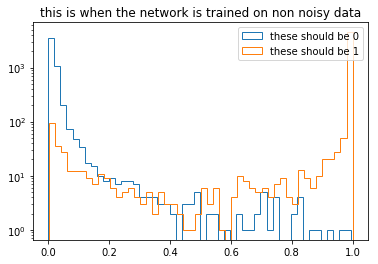

In [32]:
plt.title('this is when the network is trained on non noisy data')
labels_noisy = model.predict(X_noisy[:5000])
plt.hist(labels_noisy, bins=50, histtype='step', label='these should be 0')
plt.yscale('log')
plt.legend();

labels_noisy = model.predict(X_noisy[5000:])
plt.hist(labels_noisy, bins=50, histtype='step', label='these should be 1')
plt.yscale('log')
plt.legend();

So from this it looks like training on noisy data is just as fast and yields better results when evaluated on noisy data

In [33]:
import keras.backend as K
from keras.layers import Conv2DTranspose

In [124]:
from keras.layers import Lambda

In [125]:
def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, padding='same'):
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

In [128]:
def generator():
    X_in = Input((100,)) #np.random.random(size=100))
    X = Dense(100)(X_in)
    X = Dense(100)(X_in)
    X = Dense(100)(X_in)
    X = Conv1DTranspose(X, 2, 5)
    X = Dense(200)(X) #X = Conv1DTranspose(X_in, 5, 3)
    m = Model(inputs=X_in, outputs=X)
    m.compile(optimizer='adam', loss='mse')
    return m

In [129]:
g = generator()

ValueError: Input 0 is incompatible with layer conv2d_transpose_2: expected ndim=4, found ndim=3

In [117]:
X = np.random.random(size=(2000,100))
y = np.append(np.zeros((2000,100)),np.ones((2000,100)), 1)

In [118]:
X.shape

(2000, 100)

In [119]:
y.shape

(2000, 200)

In [120]:
g.fit(X, y, epochs=100)

Epoch 1/100
2000/2000 [==============================] - 0s 245us/step - loss: 0.1369
Epoch 2/100
2000/2000 [==============================] - 0s 87us/step - loss: 0.0334
Epoch 3/100
2000/2000 [==============================] - 0s 98us/step - loss: 0.0224
Epoch 4/100
2000/2000 [==============================] - 0s 100us/step - loss: 0.0156
Epoch 5/100
2000/2000 [==============================] - 0s 92us/step - loss: 0.0112
Epoch 6/100
2000/2000 [==============================] - 0s 99us/step - loss: 0.0084
Epoch 7/100
2000/2000 [==============================] - 0s 91us/step - loss: 0.0064
Epoch 8/100
2000/2000 [==============================] - 0s 95us/step - loss: 0.0051
Epoch 9/100
2000/2000 [==============================] - 0s 101us/step - loss: 0.0042
Epoch 10/100
2000/2000 [==============================] - 0s 100us/step - loss: 0.0035
Epoch 11/100
2000/2000 [==============================] - 0s 96us/step - loss: 0.0030
Epoch 12/100
2000/2000 [==============================] - 0

In [121]:
g.predict(np.random.random(size=(1,100)))

array([[-7.04291742e-05,  3.45103443e-04,  2.88976356e-04,
        -1.55248679e-04,  2.96020880e-05, -1.85009092e-04,
         8.68276693e-05,  1.52561814e-04,  1.40444841e-04,
         2.07316130e-04, -4.17994102e-04, -6.47456618e-05,
        -4.39528376e-05, -2.03145668e-04,  1.57325529e-04,
         1.69586856e-04,  3.17157712e-04, -1.88646838e-04,
        -5.70833217e-04,  8.19843262e-05, -6.74845651e-05,
        -4.22544777e-04,  1.88128091e-04, -1.61162345e-04,
         2.50088051e-04, -1.98580790e-04,  2.71479366e-05,
         1.60694122e-04,  2.56504864e-05,  2.93013174e-04,
         9.18414444e-05,  1.45589933e-04,  1.72420521e-04,
         4.39698808e-04,  3.26336827e-04, -3.64293810e-04,
        -5.38727269e-04, -2.18204455e-04, -4.42210585e-05,
        -3.27281188e-04, -1.02478545e-04, -8.57850537e-05,
        -1.01700425e-04, -5.60141634e-05,  3.91236623e-04,
         1.45263970e-04,  7.69360922e-04,  9.47862864e-05,
         2.11931765e-05, -4.64708311e-04, -4.35765833e-0

In [20]:
def resBlock(X, filters, k_size):
    X0 = X
    
    X = MaxPooling1D(pool_size=3)(X)
    X = Conv1D(filters, k_size, padding='same')(X)    
    X = Activation('relu')(X)

    X = MaxPooling1D(pool_size=3)(X)
    X = Conv1D(filters, k_size, padding='same')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling1D(pool_size=3)(X)
    X = Conv1D(filters, k_size, padding='same')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling1D(pool_size=3)(X)  
    
    #X = Add()([X, X0])
    return X

In [21]:
def occam_cnn(F1, K1, input_shape=(3500,1)):
    X_in = Input(input_shape)
    #X = BatchNormalization()(X_in)
    X = resBlock(X_in, F1, K1)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid')(X)
    m = Model(inputs=X_in, outputs=X, name="Occam's CNN")
    m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return m

In [22]:
model = occam_cnn(128, 64)